In [1]:
import os
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore') #, category=RuntimeWarning) # , category=FutureWarning)


from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib

import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask
import dask.array as da

import itertools

from collections import OrderedDict

import gridop as gop
import diags as dg
import plot as cplt
from model import Model
from tools import wait_cluster_ready

### Launch dask cluster

In [2]:
from dask.distributed import Client, LocalCluster

# number of cores per node
workers_per_job = 4
# number of nodes
jobs = 2
nworkers = workers_per_job * jobs

# type of cluster
config = 1

if config==1:
    # pour 1 seul noeud
    cluster = LocalCluster(n_workers=2, threads_per_worker=2)
    client = Client(cluster)
else:
    # pour plusieurs noeuds:
    # ** processes and cores may be adjusted in order to have more memory 
    # or inversely more computational ressource
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=workers_per_job, cores=workers_per_job, walltime='02:00:00')
    w = cluster.scale(jobs=jobs)
    #cluster.adapt(minimum=1, maximum=5)

    client = Client(cluster)
    wait_cluster_ready(cluster, nworkers)
    
# put tmp files of dask in the scratch directory
try:
    scratch = os.environ['SCRATCH']
except:
    scratch = os.environ['HOME']
dask.config.set(local_directory=scratch)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 110.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53903,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 110.00 GiB
Comm: tcp://127.0.0.1:51169,Total threads: 2
Dashboard: http://127.0.0.1:43121/status,Memory: 55.00 GiB
Nanny: tcp://127.0.0.1:40468,


---
### Parameters

In [3]:
# Initialisation mozambique 
# path = "/home/datawork-lops-osi/slgentil/data/moz/"
# filenames = [path+"moz_his.nc"]
# gridname = path+"moz_his.nc"
# suffix=''
# longitude = 39.
# latitude = -21.
# depth = -100.
# seldate = '2000-01-13'
# model = "croco_xios"

# # Initialisation benguela
# path = "/home/datawork-lops-osi/slgentil/data/"
# filenames = [path+"pierrick.nc"]
# gridname = path+"pierrick.nc"
# suffix=''
# longitude = 42.5
# latitude = -21.
# depth = -100.
# seldate = '4.726e+07'
# model = "croco_native"
# drop_variables = ['nav_lon_w', 'nav_lat_w',
#                   'sustr', 'svstr','bvf',
#                   'hc','h','Vtransform','sc_r','sc_w',
#                   'Cs_r','Cs_w','angle','mask_rho',
#                   'pm','pn','Tcline','theta_s','theta_b',
#                   'lon_rho','lat_rho','lon_u','lat_u','lon_v','lat_v',
#                   'nav_lon_rho','nav_lat_rho','nav_lon_u','nav_lat_u','nav_lon_v','nav_lat_v',
#                   'time_instant','time_instant_bounds',
#                   'time_counter_bounds',
#                  ]

# Initialisation gigatl6
path = "/home/datawork-lops-osi/slgentil/data/gigatl6/"
filenames = [path+'GIGATL6_12h_inst_2005-12-20-2005-12-24.nc']
gridname  = '/home/datawork-lops-megatl/GIGATL6/gigatl6_grd.nc'
suffix=''
longitude = -25.
latitude = 0.
depth = -100.
# deltat = None
seldate = '2005-12-25'
model = "croco_xios"
# drop_variables = [] #'nav_lon_w', 'nav_lat_w',
#                   'sustr', 'svstr','bvf',
#                   'hc','h','Vtransform','sc_r','sc_w',
#                   'Cs_r','Cs_w','angle','mask_rho',
#                   'pm','pn','Tcline','theta_s','theta_b',
#                   'lon_rho','lat_rho','lon_u','lat_u','lon_v','lat_v',
#                   'nav_lon_rho','nav_lat_rho','nav_lon_u','nav_lat_u','nav_lon_v','nav_lat_v',
#                   'time_instant','time_instant_bounds',
#                   'time_counter_bounds',
#                  ]


--- 
### Create an instance of the Model class 
which contains all the substitutions of the variables names depending on the model: 
- croco_xios

In [4]:
croco = Model(model)

### Open all the data files and the grid file and return a dataset. Create the xgcm grid.

In [5]:
%%time
drop_variables = [] 
ds, grid = gop.open_files(croco, gridname, filenames, grid_metrics=1, 
                          drop_variables=drop_variables, suffix=suffix,
                          chunks={'t':1},
                          # chunks={'t':1, 's':1, 's_w':1},
                         )

CPU times: user 348 ms, sys: 120 ms, total: 468 ms
Wall time: 1.3 s


In [6]:
ds

<xarray.Dataset>
Dimensions:              (s: 50, s_w: 51, y: 2000, x: 1500, x_u: 1501,
                          y_v: 2001, t: 10, axis_nbounds: 2)
Coordinates:
  * s                    (s) float32 -0.99 -0.97 -0.95 ... -0.05 -0.03 -0.01
  * s_w                  (s_w) float32 -1.0 -0.98 -0.96 ... -0.04 -0.02 0.0
    lat                  (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    lon                  (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    lat_u                (y, x_u) float32 dask.array<chunksize=(2000, 1501), meta=np.ndarray>
    lon_u                (y, x_u) float32 dask.array<chunksize=(2000, 1501), meta=np.ndarray>
    lat_v                (y_v, x) float32 dask.array<chunksize=(2001, 1500), meta=np.ndarray>
    lon_v                (y_v, x) float32 dask.array<chunksize=(2001, 1500), meta=np.ndarray>
  * t                    (t) datetime64[ns] 2005-12-20T12:00:00 ... 2005-12-25
    lon_f                (y_v, x_u) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    lat_f                (y_v, x_u) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v, axis_nbounds
Data variables: (12/34)
    nav_lat_w            (y, x) float32 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    nav_lon_w            (y, x) float32 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    time_instant         (t) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    time_instant_bounds  (t, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds  (t, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    Cs_r                 (t, s) float32 dask.array<chunksize=(1, 50), meta=np.ndarray>
    ...                   ...
    f                    (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    rho0                 float32 1.027e+03
    dx                   (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    dy                   (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    dx_u                 (y, x_u) float64 dask.array<chunksize=(2000, 1501), meta=np.ndarray>
    dy_v                 (y_v, x) float64 dask.array<chunksize=(2001, 1500), meta=np.ndarray>
Attributes: (12/45)
    name:          ./HIS/GIGATL6_12h_inst
    description:   Created by xios
    Conventions:   CF-1.6
    timeStamp:     2019-Dec-15 06:47:04 GMT
    uuid:          11ec3307-a367-49d1-8e53-fccab257ebdc
    title:         GIGATL6
    ...            ...
    x_sponge:      0.0
    v_sponge:      0.0
    sponge_expl:   Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   REGIONAL GIGATL6 MPI_TIME MPI XIOS XIOS2 OBC_EAST OBC_NORT...
    vtransform:    NEW

In [7]:
%%time
ds1 = ds.sel(t=seldate, method='nearest')
ds1

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.63 ms


<xarray.Dataset>
Dimensions:              (s: 50, s_w: 51, y: 2000, x: 1500, x_u: 1501,
                          y_v: 2001, axis_nbounds: 2)
Coordinates:
  * s                    (s) float32 -0.99 -0.97 -0.95 ... -0.05 -0.03 -0.01
  * s_w                  (s_w) float32 -1.0 -0.98 -0.96 ... -0.04 -0.02 0.0
    lat                  (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    lon                  (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    lat_u                (y, x_u) float32 dask.array<chunksize=(2000, 1501), meta=np.ndarray>
    lon_u                (y, x_u) float32 dask.array<chunksize=(2000, 1501), meta=np.ndarray>
    lat_v                (y_v, x) float32 dask.array<chunksize=(2001, 1500), meta=np.ndarray>
    lon_v                (y_v, x) float32 dask.array<chunksize=(2001, 1500), meta=np.ndarray>
    t                    datetime64[ns] 2005-12-25
    lon_f                (y_v, x_u) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    lat_f                (y_v, x_u) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v, axis_nbounds
Data variables: (12/34)
    nav_lat_w            (y, x) float32 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    nav_lon_w            (y, x) float32 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    time_instant         datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_instant_bounds  (axis_nbounds) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    time_counter_bounds  (axis_nbounds) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    Cs_r                 (s) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    ...                   ...
    f                    (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    rho0                 float32 1.027e+03
    dx                   (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    dy                   (y, x) float64 dask.array<chunksize=(2000, 1500), meta=np.ndarray>
    dx_u                 (y, x_u) float64 dask.array<chunksize=(2000, 1501), meta=np.ndarray>
    dy_v                 (y_v, x) float64 dask.array<chunksize=(2001, 1500), meta=np.ndarray>
Attributes: (12/45)
    name:          ./HIS/GIGATL6_12h_inst
    description:   Created by xios
    Conventions:   CF-1.6
    timeStamp:     2019-Dec-15 06:47:04 GMT
    uuid:          11ec3307-a367-49d1-8e53-fccab257ebdc
    title:         GIGATL6
    ...            ...
    x_sponge:      0.0
    v_sponge:      0.0
    sponge_expl:   Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   REGIONAL GIGATL6 MPI_TIME MPI XIOS XIOS2 OBC_EAST OBC_NORT...
    vtransform:    NEW

### U slice at a constant depth

CPU times: user 2.64 s, sys: 376 ms, total: 3.02 s
Wall time: 19.2 s


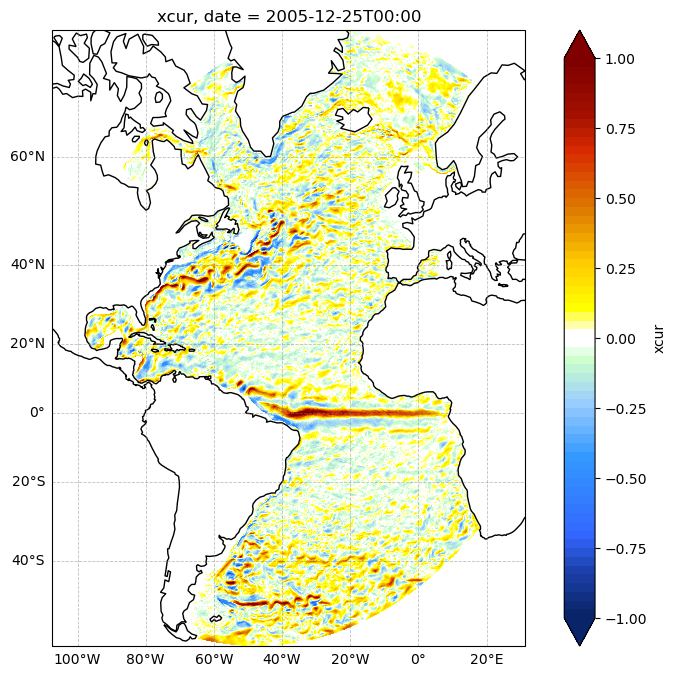

In [8]:
%%time
# depths at u points
z_u = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='u')
# slice of u at a constant depth
uslice= gop.slices(croco, ds1.xcur, z_u, ds=ds1, depth=depth)
# plot the slice of u
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(uslice, **kwargs)

### V slice at a constant depth

CPU times: user 2.88 s, sys: 380 ms, total: 3.26 s
Wall time: 12.1 s


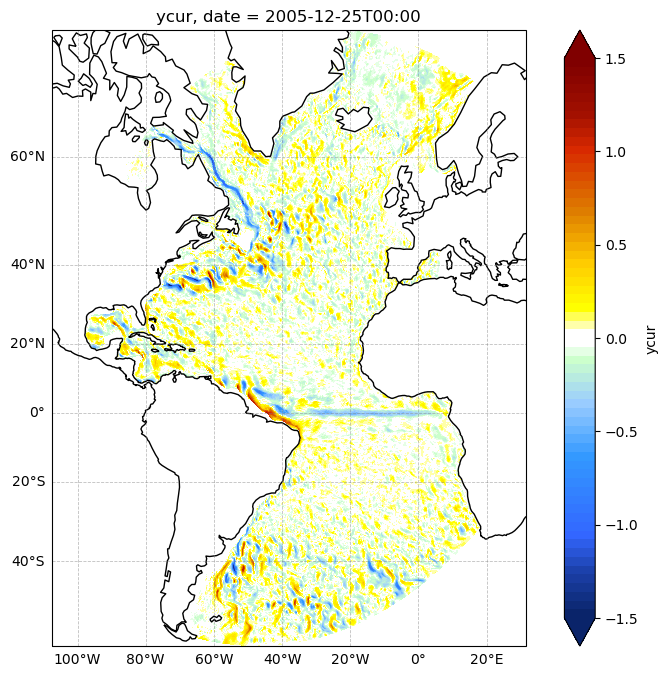

In [9]:
%%time
# depth at v points
z_v = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, hgrid='v')
# slice of v at a constant depth
# v=ds1.ycur
# v=gop.auto_chunk(v, keep_complete_dim='s', wanted_chunk=200)
vslice= gop.slices(croco, ds1.ycur, z_v, ds=ds1, depth=depth).compute()
# plot the v slice
kwargs = {'vmin': -1.5, 'vmax': 1.5, 'extend':'both'}
cplt.plotfig(vslice, **kwargs)

### Rotate u,v to lat,lon coord

In [10]:
%%time
# depth at rho points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r')
aslice= ds1.angle
# compute u_EW and v_SN
[urot,vrot] = gop.rotuv(croco, ds1, u=uslice, v=vslice, angle=aslice)

CPU times: user 1.54 s, sys: 840 ms, total: 2.38 s
Wall time: 3.31 s


### Compute relative vorticity

CPU times: user 2.9 s, sys: 476 ms, total: 3.38 s
Wall time: 12.4 s


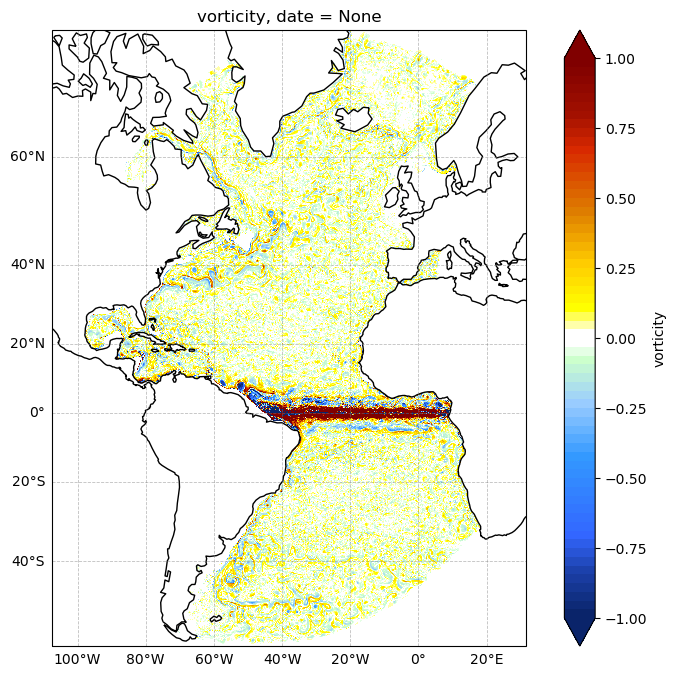

In [11]:
%%time
# compute the relative vorticity at a constant depth
relvort = dg.relative_vorticity_z(croco, ds=ds1, xgrid=grid, u=uslice, v=vslice)
# plot the relative vorticity
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(relvort, **kwargs)

### Compute dtemp/dz on a longitudinal slice

/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 372 ms, sys: 28 ms, total: 400 ms
Wall time: 7.62 s


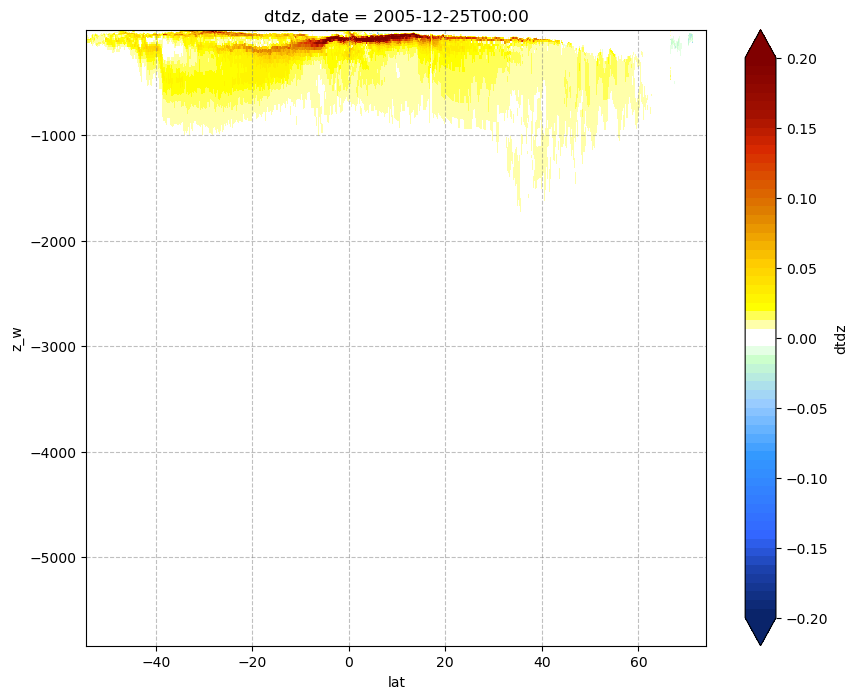

In [12]:
%%time
# longitudinal slice of temperature
tslice = gop.slices(croco, ds1.temp, z, ds=ds1, longitude=longitude)
# compute dtemp/dz
dtdz = dg.dtempdz(croco, ds=ds1, temp=tslice, z=tslice.z)
# plot dtemp/dz
kwargs = {'vmin': -0.2, 'vmax': 0.2, 'extend':'both'}
cplt.plotfig(dtdz, **kwargs)

### Compute Richardson on a longitudinal slice

/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 564 ms, sys: 116 ms, total: 680 ms
Wall time: 8.14 s


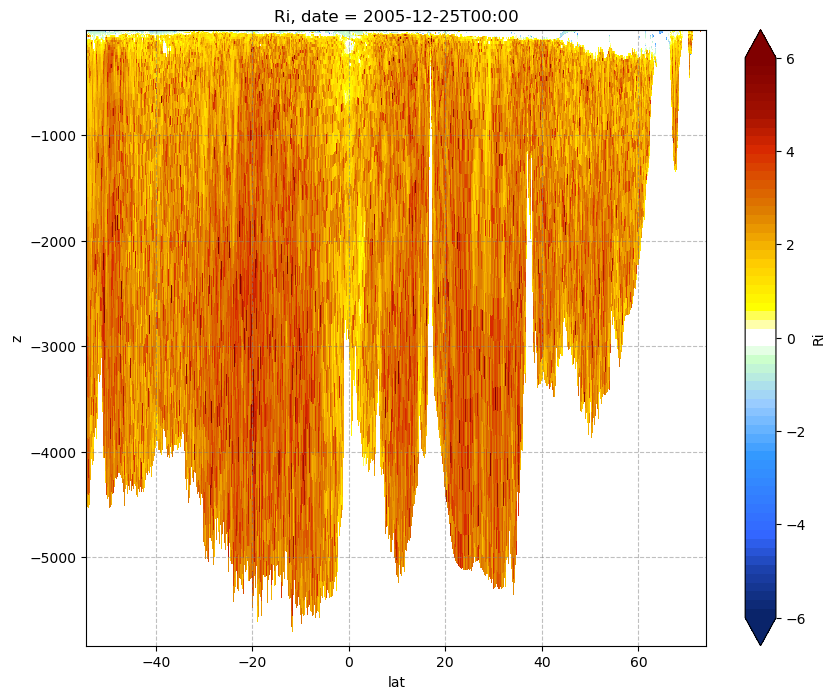

In [13]:
%%time
# longitudinal slices of rho,u,v
rslice = gop.slices(croco, ds1.rho, z, ds=ds1, longitude=longitude)
uslice = gop.slices(croco, ds1.xcur, z_u, ds=ds1, longitude=longitude)
vslice = gop.slices(croco, ds1.ycur, z_v, ds=ds1, longitude=longitude)
# compute the Richardson number
Ri = dg.richardson(croco, ds=ds1, u=uslice, v=vslice, rho=rslice, z=rslice.z)
# plot the Richardson number
kwargs = {'vmin': -6., 'vmax': 6., 'extend':'both'}
cplt.plotfig(Ri, **kwargs)

### Compute the Pressure

/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


CPU times: user 1.35 s, sys: 416 ms, total: 1.76 s
Wall time: 39.6 s


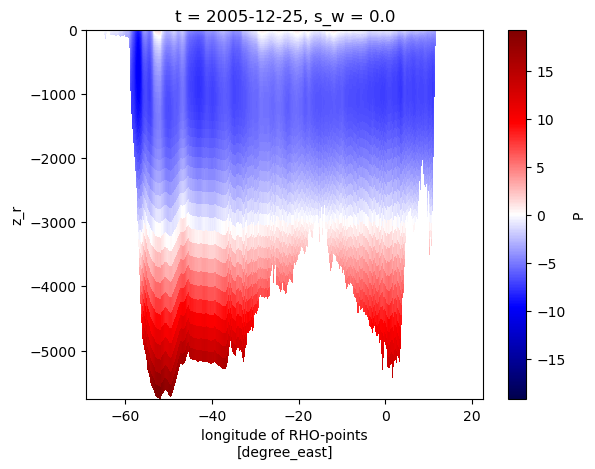

In [14]:
%%time
# depth at rho points and w points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
z_w = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='w')
# compute the pressure
P = dg.get_p(croco, ds1.rho, z_w, z, ds=ds1)
# plot the pressure
coords = gop.get_spatial_coords(P)
P.isel(y=int(P.y.size/8)).plot(x=coords['lon'], y=coords['z'], cmap="seismic")

CPU times: user 2.79 s, sys: 1 s, total: 3.8 s
Wall time: 54.2 s


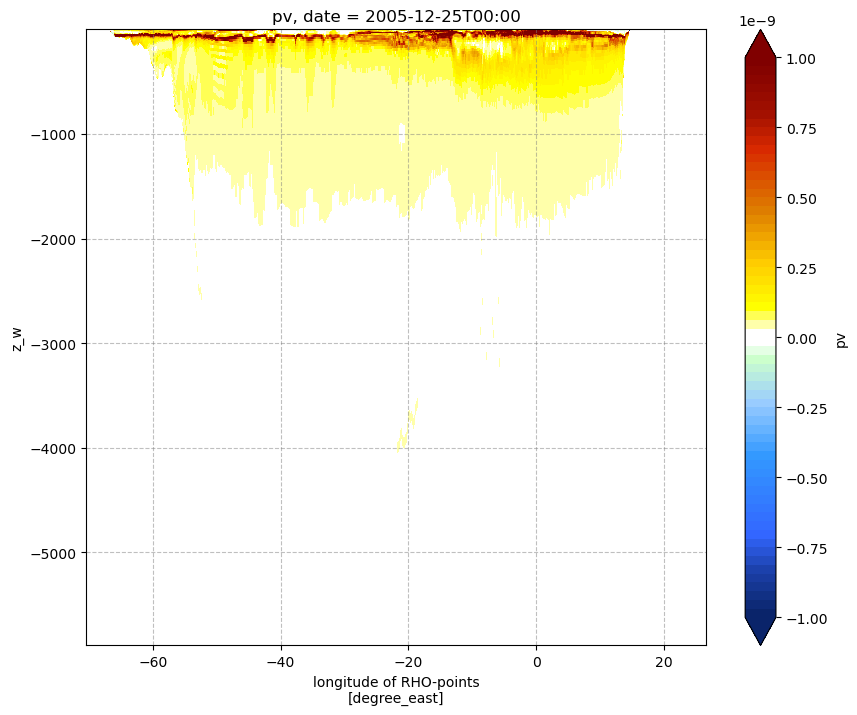

In [15]:
%%time
pv = dg.ertel_pv(croco, ds=ds1, typ='ijk')
kwargs = {'vmin': -1.e-9, 'vmax': 1.e-9, 'extend':'both'}
cplt.plotfig(pv.isel(y=128), **kwargs)


In [16]:
cluster.close()